In [1]:
from bs4 import BeautifulSoup

import pandas as pd
import os

import numpy as np

import datetime

import imageio

import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw


In [2]:
confirmed_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
confDF = pd.read_csv(confirmed_URL)

# global_path = os.path.join(os.getcwd(), 'csse_covid_19_data', 'csse_covid_19_time_series', 'time_series_covid19_confirmed_global.csv')
global_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
globalDF = pd.read_csv(global_URL)

# death_path = os.path.join(os.getcwd(), 'csse_covid_19_data', 'csse_covid_19_time_series', 'time_series_covid19_deaths_US.csv')
deathsUS_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
deathDF = pd.read_csv(deathsUS_URL)

deathsGlobal_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deathGlobalDF = pd.read_csv(deathsGlobal_URL)
# dateDict = dict(zip(confDF.columns[11:], pd.to_datetime(confDF.columns[11:])))
# confDF = confDF.rename(dateDict, axis='columns')

popPath = os.path.join(os.getcwd(), 'USpopulation.csv')
popDF = pd.read_csv(popPath)

In [3]:
byStateDF = confDF.groupby('Province_State').sum()

states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio',
       'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming']

byStateDF = byStateDF.loc[states]

deathStateDF = deathDF.groupby('Province_State').sum()

deathStateDF = deathStateDF.loc[states]

# population = confDF.set_index('Combined_Key').join(popDF[['NAME', 'POP']].set_index('NAME'))['POP']




In [4]:

# joining on FIPS code

popDF['FIPS'] = popDF['FIPS'].astype(float)
confDF['FIPS'] = confDF['FIPS'].astype(float)
confDF = confDF.set_index('FIPS').join(popDF[['FIPS', 'POP']].set_index('FIPS'))

confDF = confDF[~confDF.index.isnull()]
confDF = confDF[~confDF.POP.isnull()]


# rearranging columns so population is not at the end
columns = confDF.columns.tolist()

first = columns[:10]
first.append(columns[-1])

columns = first + columns[10:-1]

confDF = confDF[columns]

In [5]:
# find trailing average and divide by population

rate = (confDF.iloc[:,15:].diff(axis=1).rolling(window=7, axis=1).mean().iloc[:,-1] / confDF['POP']).tolist()

FIPS = [i.zfill(5) for i in confDF.index.astype(int).astype(str)]

FIPS = ['FIPS_' + num for num in FIPS]

data = pd.Series(data=rate,index=FIPS)


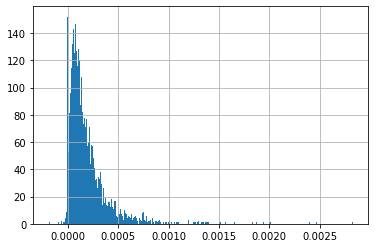

In [6]:
# check color coding intervals

hist = data.hist(bins=300)

In [7]:
# Load the SVG map
svg = open('counties.svg', 'r').read()
soup = BeautifulSoup(svg, selfClosingTags=['defs','sodipodi:namedview'])
paths = soup.findAll('path')

# Map colors
colors = ["#F1EEF6", "#D4B9DA", "#C994C7", "#DF65B0", "#DD1C77", "#980043"]
 
# County style
path_style = 'font-size:12px;fill-rule:nonzero;stroke:#FFFFFF;stroke-opacity:1; stroke-width:0.1;stroke-miterlimit:4;stroke-dasharray:none;stroke-linecap:butt; marker-start:none;stroke-linejoin:bevel;fill:'

In [8]:
# Color the counties
# for p in paths:
     
#     if p['id'] not in ["State_Lines", "separator"]:
#         # pass
#         try:
#             rate = data[data.index == p['id']].item()
#         except:
#             continue

#         # print(rate) 
#         if rate > 0.001:
#             color_class = 5
#         elif rate > 0.0008:
#             color_class = 4
#         elif rate > 0.0006:
#             color_class = 3
#         elif rate > 0.0004:
#             color_class = 2
#         elif rate > 0.0002:
#             color_class = 1
#         else:
#             color_class = 0
 
#         color = colors[color_class]
#         p['style'] = path_style + color

# # Output map
# COVIDmap = soup.prettify()

# with open('map.svg', 'w') as file:
#     file.write(COVIDmap)


In [9]:
# https://electionlab.mit.edu/data

electionPath = os.path.join(os.getcwd(), 'countypres_2000-2016.csv')
electionDF = pd.read_csv(electionPath)



In [10]:
only2016 = electionDF[electionDF['year'] == 2016]

FIPScodes = only2016.FIPS.unique().tolist()

In [11]:
electionFIPS = pd.Series(dtype=str)

for code in FIPScodes:
    try:
        temp = only2016[only2016['FIPS'] == code]
        # print(code)
        temp = temp[temp['candidatevotes'] == temp['candidatevotes'].max()]
        # print(temp)
        electionFIPS = electionFIPS.append(pd.Series(data=temp['party'].item(), index=[('FIPS_' + temp['FIPS'].astype(int).astype(str).item().zfill(5))], dtype=str))
    except:
        print(code)


51515.0
nan


In [12]:
data = pd.DataFrame(data)
electionFIPS = pd.DataFrame(electionFIPS)

data = pd.merge(data, electionFIPS, left_index=True, right_index=True)

In [13]:
columns = ['rate', 'voting']

data = data.rename(columns=dict(zip(data.columns, columns)))

In [14]:
# Load the SVG map
svg = open('counties.svg', 'r').read()
soup = BeautifulSoup(svg, selfClosingTags=['defs','sodipodi:namedview'])
paths = soup.findAll('path')

# Map colors https://colorbrewer2.org/#type=sequential&scheme=Blues&n=6
blueColors = ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']
redColors = ['#fee5d9','#fcbba1','#fc9272','#fb6a4a','#de2d26','#a50f15']

 
# County style
path_style = 'font-size:12px;fill-rule:nonzero;stroke:#FFFFFF;stroke-opacity:1; stroke-width:0.1;stroke-miterlimit:4;stroke-dasharray:none;stroke-linecap:butt; marker-start:none;stroke-linejoin:bevel;fill:'

In [15]:
# # Color the counties based on new infections per capita
# for p in paths:
     
#     if p['id'] not in ["State_Lines", "separator"]:
#         # pass
#         try:
#             rate = data[data.index == p['id']].rate.item()
#         except:
#             continue

#         # #-------------------------------- 
#         # if rate > 0.001:
#         #     color_class = 5
#         # elif rate > 0.0008:
#         #     color_class = 4
#         # elif rate > 0.0006:
#         #     color_class = 3
#         # elif rate > 0.0004:
#         #     color_class = 2
#         # elif rate > 0.0002:
#         #     color_class = 1
#         # else:
#         #     color_class = 0



#         # ----------- SENSITIVE ----------------
#         if rate > 0.00025:
#             color_class = 5
#         elif rate > 0.0002:
#             color_class = 4
#         elif rate > 0.00015:
#             color_class = 3
#         elif rate > 0.0001:
#             color_class = 2
#         elif rate > 0.00005:
#             color_class = 1
#         else:
#             color_class = 0
        
 
#         if data[data.index == p['id']].voting.item() == 'democrat':
#             color = blueColors[color_class]
#         if data[data.index == p['id']].voting.item() == 'republican':
#             color = redColors[color_class]
#         p['style'] = path_style + color

# # Output map
# COVIDmap = soup.prettify()

# with open('mapByParty.svg', 'w') as file:
#     file.write(COVIDmap)


In [16]:
data

,rate,voting
FIPS_01001,0.000187,republican
FIPS_01003,0.000308,republican
FIPS_01005,0.000220,republican
FIPS_01007,0.000147,republican
FIPS_01009,0.000119,republican
...,...,...
FIPS_56037,0.000044,republican
FIPS_56039,0.000329,democrat
FIPS_56041,0.000106,republican
FIPS_56043,0.000055,republican


In [17]:
len(confDF.iloc[:,11:].columns)

252

In [18]:
everyXdays = 3

temp = confDF.iloc[:,11:].diff(axis=1).rolling(window=7, axis=1).mean()

temp = temp.iloc[:,list(range(0,len(temp.columns.tolist()),everyXdays))].dropna(axis='columns')

temp = temp.div(confDF['POP'], axis=0)

data = temp

data[data < 0] = 0


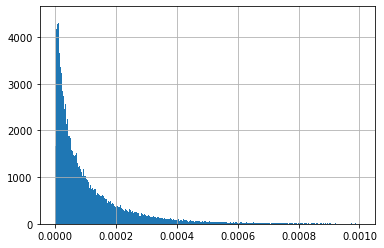

In [19]:
data[(data != 0) & (data < .001)].stack().hist(bins=500)

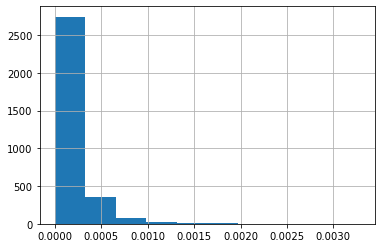

In [20]:
data.iloc[:,-1].hist()

In [21]:
# binBoundaries = list(np.linspace(data.min().min(), data.max().max(), num=8))

# binBoundaries = list(np.linspace(0, .00025, num=7))

binBoundaries = list(np.linspace(0, .001, num=10))

In [22]:
binBoundaries

[0.0,
 6.666666666666666e-05,
 0.0001333333333333333,
 0.00019999999999999998,
 0.0002666666666666666,
 0.00033333333333333327,
 0.00039999999999999996,
 0.0004666666666666666,
 0.0005333333333333333,
 0.0006]

In [23]:
data = data.iloc[:,10:]

In [24]:
# colors = ["#F1EEF6", "#D4B9DA", "#C994C7", "#DF65B0", "#DD1C77", "#980043"]


colors = ['#fcfbfd','#efedf5','#dadaeb','#bcbddc','#9e9ac8','#807dba','#6a51a3','#54278f','#3f007d']

# Load the SVG map
svg = open('counties.svg', 'r').read()
soup = BeautifulSoup(svg, selfClosingTags=['defs','sodipodi:namedview'])
paths = soup.findAll('path')

names = [datetime.datetime.strptime(date, '%m/%d/%y') for date in data.columns]

# County style
path_style = 'font-size:12px;fill-rule:nonzero;stroke:#FFFFFF;stroke-opacity:1; stroke-width:0.1;stroke-miterlimit:4;stroke-dasharray:none;stroke-linecap:butt; marker-start:none;stroke-linejoin:bevel;fill:'

# rename rows to match id in map
FIPSnames = [i.zfill(5) for i in data.index.astype(int).astype(str)]
FIPSnames = ['FIPS_' + num for num in FIPSnames]
data = data.rename(index=dict(zip(data.index, FIPSnames)))

for colNum in range(len(data.columns.tolist())):

    temp = data.iloc[:,colNum]
    for p in paths:
        
        if p['id'] not in ["State_Lines", "separator"]:

            try:
                rate = temp[temp.index == p['id']].item()
            except:
                continue

            # print(rate) 
            if rate > binBoundaries[8]:
                color_class = 8
            elif rate > binBoundaries[7]:
                color_class = 7
            elif rate > binBoundaries[6]:
                color_class = 6
            elif rate > binBoundaries[5]:
                color_class = 5
            elif rate > binBoundaries[4]:
                color_class = 4
            elif rate > binBoundaries[3]:
                color_class = 3
            elif rate > binBoundaries[2]:
                color_class = 2
            elif rate > binBoundaries[1]:
                color_class = 1
            else:
                color_class = 0
    
            color = colors[color_class]
            p['style'] = path_style + color

    # Output map
    COVIDmap = soup.prettify()

    path = os.path.join(os.getcwd(), 'maps', str(names[colNum].date()) + 'map.svg')
    with open(path, 'w') as file:
        file.write(COVIDmap)


In [25]:
list(np.linspace(data.min().min(), data.max().max(), num=8))

[0.0,
 0.002347553697125784,
 0.004695107394251568,
 0.007042661091377351,
 0.009390214788503135,
 0.011737768485628918,
 0.014085322182754703,
 0.016432875879880487]

In [26]:
import cairosvg

img_path = os.path.join(os.getcwd(), 'maps')
filenames = os.listdir(img_path)
save_path = os.path.join(os.getcwd(), 'animatedMap.gif')

filenames = [name for name in filenames if not '.png' in name]

d = "maps"
filenames = []
for path in os.listdir(d):
    full_path = os.path.join(d, path)
    if os.path.isfile(full_path):
        filenames.append(full_path)

filenames = [name for name in filenames if not '.png' in name]



In [27]:

outNames = [name.replace('svg', 'png') for name in filenames]


for i in range(0,len(filenames)): 
    cairosvg.svg2png(url=filenames[i], write_to=outNames[i], scale=3)


In [28]:
img_path = os.path.join(os.getcwd(), 'maps')
filenames = os.listdir(img_path)
save_path = os.path.join(os.getcwd(), 'animatedMap.gif')

d = "maps"
filenames = []
for path in os.listdir(d):
    full_path = os.path.join(d, path)
    if os.path.isfile(full_path):
        filenames.append(full_path)

filenames = [name for name in filenames if not '.svg' in name]

In [49]:


titles = data.columns.tolist()

for i in range(0, len(filenames)):

    mapTitle = 'COVID-19 New Infections Adjusted for Population ' + titles[i]


    font = ImageFont.truetype("UniversLTStd-BoldCn.otf",25)
    # img=Image.new("RGBA", (200,200),(120,20,20))

    img = Image.open(filenames[i])

    draw = ImageDraw.Draw(img)
    draw.text((600, 30), mapTitle, (0,0,0), font=font)
    
    legend = Image.open('legend.png')
    img.paste(legend, (1500,650))

    draw = ImageDraw.Draw(img)

    footer = ImageFont.truetype("UniversLTStd-BoldCn.otf",16)
    draw.text((800, 1030), 'Sources: CSSE Johns Hopkins COVID Data, US Census Bureau, MIT Election Lab      by: UBERCRUZER', (0,0,0), font=footer)
    draw = ImageDraw.Draw(img)

    img.save(filenames[i])





In [50]:

images = []
for filename in outNames:
    images.append(imageio.imread(filename))
imageio.mimsave(save_path, images, duration=1)


In [48]:



img = Image.open(filenames[-1])
draw = ImageDraw.Draw(img)


img.save('a_test.png')